In [1]:
import numpy as np

import skrf
from skrf.media import DistributedCircuit
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.4, 2, 1001)
tem = DistributedCircuit(f, z0=50)

bjt = net.Network('BFU520_Spar_NF_400MHz-2GHz/BFU520_05V0_005mA_NF_SP.s2p').interpolate(f)

bjt

2-Port Network: 'BFU520_05V0_005mA_NF_SP',  0.4-2.0 GHz, 1001 pts, z0=[ 50.+0.j  50.+0.j]

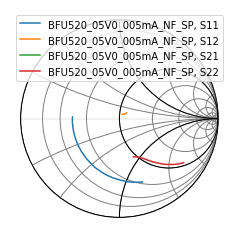

In [2]:
bjt.plot_s_smith()

In [3]:
# let's add an inductor to the emitter
# to do this we need a function that lets you combine two port networks in series
# so we can model it
from scipy.interpolate import interp1d

def series(a, b):
  newz = a.z + b.z

  ret = net.Network.from_z(newz, frequency=a.frequency)
  noiseless = not a.noisy and not b.noisy
  if noiseless:
    return ret
  if a.noisy:
    an = a.n
    af = a.f_noise
  else:
    an = np.zeros(b.n.shape)
    af = b.f_noise
  if b.noisy:
    bn = b.n
    bf = b.f_noise
  else:
    bn = np.zeros(a.n.shape)
    bf = a.f_noise

  if bf != af:
    # TODO interpolate noise values for b into a frequency ranges
    # bn = ??? 
    raise NotImplementedError

  a_real = interp1d(a.frequency.f, a.a.real, 
          axis=0, kind=net.Network.noise_interp_kind)
  a_imag = interp1d(a.frequency.f, a.a.imag, 
          axis=0, kind=net.Network.noise_interp_kind)
  a_abcd = a_real(af.f) + 1.j * a_imag(af.f)

  b_real = interp1d(b.frequency.f, b.a.real, 
          axis=0, kind=net.Network.noise_interp_kind)
  b_imag = interp1d(b.frequency.f, b.a.imag, 
          axis=0, kind=net.Network.noise_interp_kind)
  b_abcd = b_real(bf.f) + 1.j * b_imag(bf.f)

  # calculate noise
  # based on https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119073093.app3
  a1 = 1
  b1 = (b_abcd[:,0,0] - a_abcd[:,0,0])/(a_abcd[:,1,0] + b_abcd[:,1,0])
  c1 = 0
  d1 = b_abcd[:,1,0]/(a_abcd[:,1,0] + b_abcd[:,1,0])

  a2 = 1
  b2 = (a_abcd[:,0,0] - b_abcd[:,0,0])/(a_abcd[:,1,0] + b_abcd[:,1,0])
  c2 = 0
  d2 = a_abcd[:,1,0]/(a_abcd[:,1,0] + b_abcd[:,1,0])

  ee = (a1*np.conj(a1)*an[:,0,0] + b1*np.conj(b1)*bn[:,1,1] +
          a2*np.conj(a2)*bn[:,1,1] + b2*np.conj(b2)*bn[:,1,1] +
      a1*np.conj(b1)*an[:,0,1] + b1*np.conj(a1)*an[:,1,0] +
          a2*np.conj(b2)*bn[:,0,1] + b2*np.conj(a2)*bn[:,1,0])
  ii = (c1*np.conj(c1)*an[:,0,0] + d1*np.conj(d1)*an[:,1,1] +
          c2*np.conj(c2)*bn[:,0,0] + d2*np.conj(d2)*bn[:,1,1] +
      c1*np.conj(d1)*an[:,0,1] + d1*np.conj(c1)*an[:,1,0] +
        c2*np.conj(d2)*bn[:,0,1] + d2*np.conj(c2)*bn[:,1,0])
  ei = (a1*np.conj(c1)*an[:,0,0] + b1*np.conj(d1)*an[:,1,1] + 
          a2*np.conj(c2)*bn[:,0,0] + b2*np.conj(d2)*bn[:,1,1] + 
      a1*np.conj(d1)*an[:,0,1] + b1*np.conj(c1)*an[:,1,0] + 
        a2*np.conj(d2)*bn[:,0,1] + b2*np.conj(c2)*bn[:,1,0])
  ie = np.conj(ei)

  ret.noise = np.moveaxis(np.array([[ee, ei], [ie, ii]]), 2, 0)
  ret.noise_freq = af
  return ret

(58.285348012831371+12.185071598304109j)

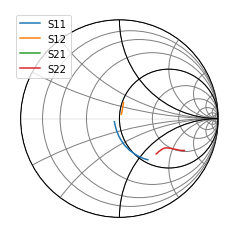

In [4]:
bjt_degen = series(bjt, tem.shunt_inductor(1e-9))
bjt_degen.plot_s_smith()

idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)
bjt_degen.z_opt[idx_900mhz]

In [5]:
# calculate the stability circles for the source and load impedances

idx_900mhz = skrf.util.find_nearest_index(bjt_degen.f, 915.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt_degen.s11.s*bjt_degen.s22.s - bjt_degen.s12.s*bjt_degen.s21.s
rl = np.absolute((bjt_degen.s12.s * bjt_degen.s21.s)/(sqabs(bjt_degen.s22.s) - sqabs(delta)))
cl = np.conj(bjt_degen.s22.s - delta*np.conj(bjt_degen.s11.s))/(sqabs(bjt_degen.s22.s) - sqabs(delta))

rl_900mhz = rl[idx_900mhz][0, 0]
cl_900mhz = cl[idx_900mhz][0, 0]

rl_900mhz, cl_900mhz

(3.048555602935056, (3.001540263823371+2.6459699316881777j))

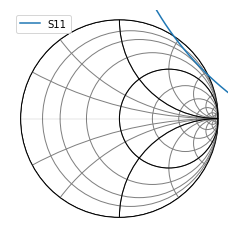

In [6]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()
    
cl_points = calc_circle(cl_900mhz, rl_900mhz)
plot_smith(cl_points)

In [7]:
rs = np.absolute((bjt_degen.s12.s * bjt_degen.s21.s)/(sqabs(bjt_degen.s11.s) - sqabs(delta)))
cs = np.conj(bjt_degen.s11.s - delta*np.conj(bjt_degen.s22.s))/(sqabs(bjt_degen.s11.s) - sqabs(delta))

rs_900mhz = rs[idx_900mhz][0, 0]
cs_900mhz = cs[idx_900mhz][0, 0]

rs_900mhz, cs_900mhz

(3.267143687859595, (1.6731769925739743-1.6577383735222198j))

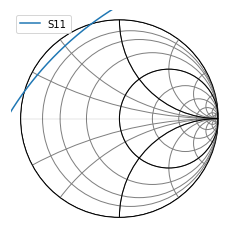

In [8]:
cs_points = calc_circle(cs_900mhz, rs_900mhz)
plot_smith(cs_points)

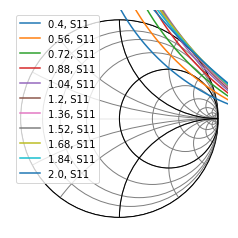

In [9]:
# let's plot all of them
# output stability first

for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

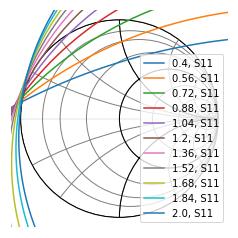

In [10]:
# input stability
for i, f in enumerate(bjt.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

the optimum source reflection coefficient is  (0.0880613782526+0.102618106726j)


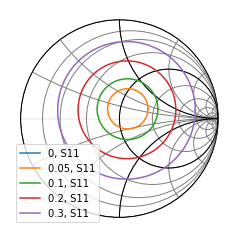

In [11]:
# let's draw some constant noise circles
# first we grab the noise parameters for our target frequency from the network model
idx_915mhz = skrf.util.find_nearest_index(bjt_degen.f, 915.e+6)

# we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
rn = bjt_degen.rn[idx_915mhz]/50
gamma_opt = bjt_degen.g_opt[idx_915mhz]
fmin = bjt_degen.nfmin[idx_915mhz]

for nf_added in [0, 0.05, 0.1, 0.2, 0.3]:
    nf = 10**(nf_added/10) * fmin
    
    N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
    c_n = gamma_opt/(1+N)
    r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))
    
    n = net.Network(name=str(nf_added), s=calc_circle(c_n, r_n))
    n.plot_s_smith()

print("the optimum source reflection coefficient is ", gamma_opt)

In [12]:
gamma_s = bjt_degen.g_opt[idx_900mhz]
gamma_s

(0.088061378252587419+0.10261810672607581j)

In [13]:
# so I need to calculate the load reflection coefficient to get a conjugate match when the input sees 50 ohms
gamma_l = np.conj(bjt_degen.s22.s - bjt_degen.s21.s*gamma_s*bjt_degen.s12.s/(1-bjt_degen.s11.s*gamma_s))
is_gamma_l_stable = np.absolute(gamma_l[idx_900mhz, 0, 0] - cl_900mhz) > rl_900mhz

gamma_l = gamma_l[idx_900mhz, 0, 0]
gamma_l, is_gamma_l_stable

((0.53933106007665532+0.26530128140907783j), True)

In [14]:
def calc_matching_network_vals(z1, z2):
    flipped = ((abs(np.imag(z2)) < 1e-6 and np.real(z1) < np.real(z2)) or
            (abs(np.imag(z2)) > 1e-6 and np.real(z1) < np.real(1/(1/z2-1/(1.j*np.imag(z2))))))
    if flipped:
        z2, z1 = z1, z2
        
    # cancel out the imaginary parts of both input and output impedances    
    z1_par = 1e+10
    if abs(np.imag(z1)) > 1e-6:
        # parallel something to cancel out the imaginary part of
        # z1's impedance
        z1_par = 1/(-1j*np.imag(1/z1))
        z1 = 1/(1./z1 + 1/z1_par)
    z2_ser = 0.0
    if abs(np.imag(z2)) > 1e-6:
        z2_ser = -1j*np.imag(z2)
        z2 = z2 + z2_ser
        
    Q = np.sqrt((np.real(z1) - np.real(z2))/np.real(z2))
    x1 = -1.j * np.real(z1)/Q
    x2 = 1.j * np.real(z2)*Q
    
    x1_tot = 1/(1/z1_par + 1/x1)
    x2_tot = z2_ser + x2
    if flipped:
        return x2_tot, x1_tot
    else:
        return x1_tot, x2_tot

z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]
# note that we're matching against the conjugate;
# this is because we want to see z_l from the BJT side
# if we plugged in z the matching network would make
# the 50 ohms look like np.conj(z) to match against it, so
# we use np.conj(z_l) so that it'll look like z_l from the BJT's side
z_par, z_ser = calc_matching_network_vals(np.conj(z_l), 50)
z_l, z_par, z_ser

((113.01057791499088+93.878513301282439j),
 -225.08350870216864j,
 83.96308091204551j)

In [15]:
# let's calculate what the component values are
c_par = np.real(1/(2j*np.pi*915e+6*z_par))
l_ser = np.real(z_ser/(2j*np.pi*915e+6))

c_par, l_ser

(7.727790877202402e-13, 1.4604523895493778e-08)

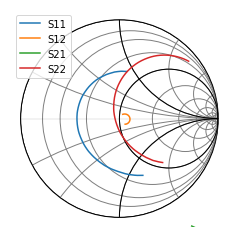

In [16]:
# the capacitance is kind of low but the inductance seems reasonable
# let's test it out

output_network = tem.shunt_capacitor(c_par) ** tem.inductor(l_ser)

amplifier = tem.inductor(0.9e-9) ** bjt_degen ** output_network

amplifier.plot_s_smith()

0.7680949467294812

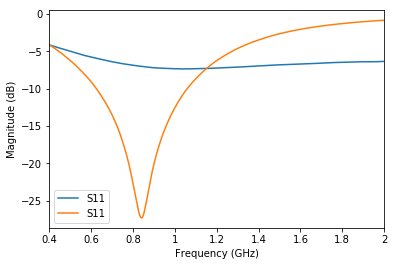

In [17]:
amplifier.s11.plot_s_db()
amplifier.s22.plot_s_db()
10*np.log10(amplifier.nf(50.)[idx_900mhz])

(8.0997171982931437+2.8002337270131945j)

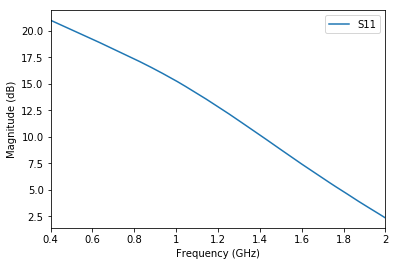

In [18]:
amplifier.s21.plot_s_db()
10*np.log10(np.abs(amplifier.s21.s[idx_900mhz,0,0]))

In [ ]:
# that's pretty good but let's try to optimize the inductor value so we can get conjugate matching
# at the same time as minimum noise figure

nf_min = 10e+9
lval = 0.0
gamma_s_opt = None
gamma_l_opt = None
best_zs_opt = None
for l in np.linspace(0, 5e-9, 50):
    bjt_degen = series(bjt, tem.shunt_inductor(l))
    #bjt_degen.plot_s_smith()

    idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)
    zs_opt = bjt_degen.z_opt[idx_900mhz]
    
    bjt_s11 = bjt_degen.s11.s[idx_900mhz,0,0]
    bjt_s12 = bjt_degen.s12.s[idx_900mhz,0,0]
    bjt_s21 = bjt_degen.s21.s[idx_900mhz,0,0]
    bjt_s22 = bjt_degen.s22.s[idx_900mhz,0,0]

    delta2 = bjt_s11*bjt_s22 - bjt_s12*bjt_s21

    B1 = 1 + sqabs(bjt_s11) - sqabs(bjt_s22) - sqabs(delta2)
    B2 = 1 + sqabs(bjt_s22) - sqabs(bjt_s11) - sqabs(delta2)
    C1 = bjt_s11 - delta2*np.conj(bjt_s22)
    C2 = bjt_s22 - delta2*np.conj(bjt_s11)

    gamma_s = (B1 - np.sqrt(np.square(B1) - 4*sqabs(C1) + 0j))/(2*C1)
    gamma_l = (B2 - np.sqrt(np.square(B2) - 4*sqabs(C2) + 0j))/(2*C2)

    zs_loop = net.z2s(np.array([[[zs_opt]]]))[0,0,0]
    nf_loop = bjt_degen.nf(zs_loop)[idx_900mhz]
    if nf_loop < nf_min:
        nf_min = nf_loop
        lval = l
        gamma_s_opt = gamma_s
        gamma_l_opt = gamma_l
        best_zs_opt = zs_opt
        
(lval, best_zs_opt, gamma_s_opt, gamma_l_opt, zdiff_min)

/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/media.py:527: RuntimeWarning: divide by zero encountered in true_divide
  y[:,0,0] = 1./(1j*w*L)
/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/media.py:527: RuntimeWarning: invalid value encountered in true_divide
  y[:,0,0] = 1./(1j*w*L)
/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/media.py:528: RuntimeWarning: divide by zero encountered in true_divide
  y[:,1,1] = 1./(1j*w*L)
/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/media.py:528: RuntimeWarning: invalid value encountered in true_divide
  y[:,1,1] = 1./(1j*w*L)
/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/media.py:529: RuntimeWarning: divide by zero encountered in true_divide
  y[:,0,1] = -1./(1j*w*L)
/home/kelvin/.local/lib/python3.6/site-packages/scikit_rf-0.14.8-py3.6.egg/skrf/media/

In [20]:
zdiff_min

0.71654949035834925

In [37]:
bjt.nf(2000.)

array([ 3.72602812,  3.71656633,  3.70710454, ...,  7.36023507,
        7.37740223,  7.3945694 ])

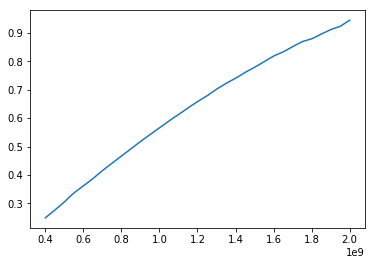

In [21]:
# that's probably good enough for the first stage
# for the second stage let's stabilize the transistor by adding some parallel resistance
# and then simultaneous conjugate matching so that both the input and output are matched to 50 ohms

# let's calculate the stability factor to see where it's unstable
sqabs = lambda x: np.square(np.absolute(x))
delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
K = ((1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta))/(2*np.absolute(bjt.s12.s*bjt.s21.s)))[:,0,0]

plt.plot(bjt.f, K)

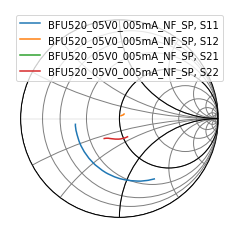

In [22]:
#so it's basically always unstable
#let's add a 250 ohm shunt to the output and see how much that improves it

bjt_comp = bjt ** tem.shunt(tem.resistor(75.) ** tem.short())
bjt_comp.plot_s_smith()

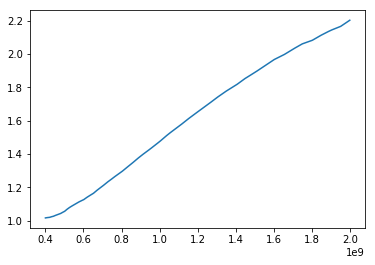

In [23]:
# let's calculate K again
delta2 = bjt_comp.s11.s*bjt_comp.s22.s - bjt_comp.s12.s*bjt_comp.s21.s
K2 = ((1 - sqabs(bjt_comp.s11.s) - sqabs(bjt_comp.s22.s) + sqabs(delta2))/(2*np.absolute(bjt_comp.s12.s*bjt_comp.s21.s)))[:,0,0]

plt.plot(bjt_comp.f, K2)

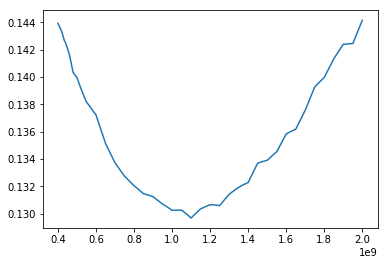

In [24]:
# that's a pretty nice improvement! let's check the delta to be sure, and
# find the new source stability circles to see if we need to add some series resistance there

# K > 1 and |delta| < 1 for stability
plt.plot(bjt_comp.f, np.absolute(delta2[:,0,0]))

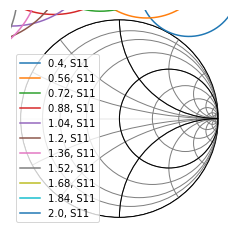

In [25]:
rs2 = np.absolute((bjt_comp.s12.s * bjt_comp.s21.s)/(sqabs(bjt_comp.s11.s) - sqabs(delta2)))
cs2 = np.conj(bjt_comp.s11.s - delta2*np.conj(bjt_comp.s22.s))/(sqabs(bjt_comp.s11.s) - sqabs(delta2))

# input stability
for i, f in enumerate(bjt_comp.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs2[i][0, 0], rs2[i][0, 0]))
    n.plot_s_smith()

In [26]:
# that doesn't look too bad, so let's move forward and try to conjugate match
delta2 = bjt_comp.s11.s*bjt_comp.s22.s - bjt_comp.s12.s*bjt_comp.s21.s

B1 = 1 + sqabs(bjt_comp.s11.s) - sqabs(bjt_comp.s22.s) - sqabs(delta2)
B2 = 1 + sqabs(bjt_comp.s22.s) - sqabs(bjt_comp.s11.s) - sqabs(delta2)
C1 = bjt_comp.s11.s - delta2*np.conj(bjt_comp.s22.s)
C2 = bjt_comp.s22.s - delta2*np.conj(bjt_comp.s11.s)

gamma_s_all = (B1 - np.sqrt(np.square(B1) - 4*sqabs(C1) + 0j))/(2*C1)
gamma_l_all = (B2 - np.sqrt(np.square(B2) - 4*sqabs(C2) + 0j))/(2*C2)

gamma_s = gamma_s_all[idx_900mhz, 0, 0]
gamma_l = gamma_l_all[idx_900mhz, 0, 0]

z_s = net.s2z(np.array([[[gamma_s]]]))[0,0,0]
z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]

# this section broke when I switched to a lower bias current so just ignore this
z_s, z_l

((14.453769011425337+31.967494868137187j),
 (28.41148437701095+33.098424068469981j))

In [27]:
x_s_1, x_s_2 = calc_matching_network_vals(np.conj(z_s), 50)
x_l_1, x_l_2 = calc_matching_network_vals(np.conj(z_l), 50)

x_s_1, x_s_2, x_l_1, x_l_2

(54.634144641220715j,
 (1.0165472266293926e-07-31.88333775860665j),
 57.8645657612208j,
 (3.290115549532768e-07-57.35952884685131j))

In [28]:
c_s_shunt = np.real(1/(2j*np.pi*915e+6*x_s_1))
c_s_ser = np.real(1/(2j*np.pi*915e+6*x_s_2))
l_s_ser = np.real(x_s_2/(2j*np.pi*915e+6))
c_l_shunt = np.real(1/(2j*np.pi*915e+6*x_l_1))
l_l_ser = np.real(x_l_2/(2j*np.pi*915e+6))

c_s_shunt2 = np.real(1/(2j*np.pi*915e+6*x_s_2))
l_s_ser2 = np.real(x_s_1/(2j*np.pi*915e+6))

c_l_shunt2 = np.real(1/(2j*np.pi*915e+6*x_l_2))
l_l_ser2 = np.real(x_l_1/(2j*np.pi*915e+6))

#c_s_shunt, c_s_ser, c_l_shunt, l_l_ser
c_s_shunt2, l_s_ser2, c_l_shunt2, l_l_ser2

(5.4555087623716236e-12,
 9.503053749997663e-09,
 3.032448697062142e-12,
 1.0064952645644079e-08)

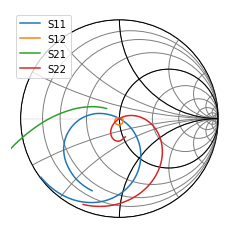

In [29]:
#input_network2 = tem.capacitor(c_s_ser) ** tem.shunt_capacitor(c_s_shunt)
#input_network2 = tem.inductor(l_s_ser) ** tem.shunt_capacitor(c_s_shunt)
input_network2 = tem.shunt_capacitor(c_s_shunt2) ** tem.inductor(l_s_ser2)

#output_network2 = tem.shunt_capacitor(c_l_shunt) ** tem.inductor(l_l_ser)
output_network2 = tem.inductor(l_l_ser2) ** tem.shunt_capacitor(c_l_shunt2)

amplifier2 = input_network2 ** bjt_comp ** output_network2
#amplifier2 = input_network2 ** bjt #** output_network2

amplifier2.plot_s_smith()

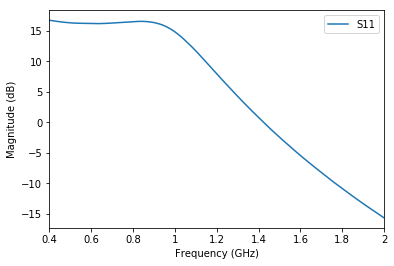

In [30]:
amplifier2.s21.plot_s_db()

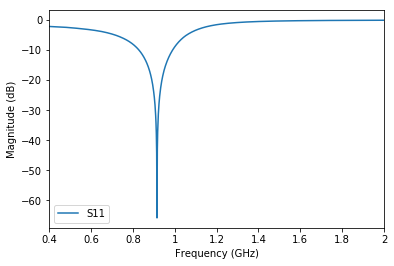

In [31]:
amplifier2.s11.plot_s_db()

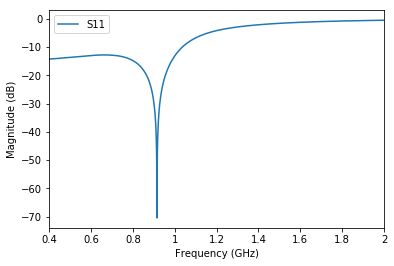

In [32]:
amplifier2.s22.plot_s_db()

In [33]:
10*np.log10(amplifier2.nf(50.)[idx_900mhz])

1.5225393220600005

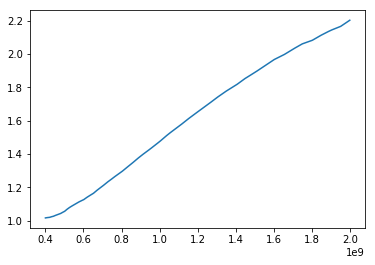

In [34]:
# check stability again
delta2 = amplifier2.s11.s*amplifier2.s22.s - amplifier2.s12.s*amplifier2.s21.s
K2 = ((1 - sqabs(amplifier2.s11.s) - sqabs(amplifier2.s22.s) + sqabs(delta2))/(2*np.absolute(amplifier2.s12.s*amplifier2.s21.s)))[:,0,0]

plt.plot(amplifier2.f, K2)